## Checking the strategy on the generated series
#### 12.05.2019

In [1]:
# connection necessary packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

## Helpfull functions

In [185]:
# Series generator
def series(length, mu, sigma, N=16):
    leng = length / N
    ser = np.random.normal(mu/leng, sigma/np.sqrt(leng), length)
    return ser


# capital increase
def cap_in(data_list):
    data_list[0] = 1
    for i in range(1, len(data_list)):
        b = i - 1
        data_list[i] = data_list[b] * (1 + data_list[i])
    return data_list


# Flag of the data frame
def flag(df, n_assets=2):
    df['Flag'] = 0
    df.iloc[0, n_assets] = 1
    num = 0
    for i in range(len(df)):
        num += 1
        if num == 252:
            df.iloc[i, n_assets] = 1
            num = 0
    num = 0
    
    
# Filter
def filter_df(df, start, stop):
        df = df[df.index >= start]
        df = df[df.index < stop]
        return df


# Cost increase generator
def future(length, ret, vol, n_test=100):
    np.random.seed()
    temp = pd.DataFrame([[np.random.normal(ret, vol) for i in range(n_test)] for j in range(length)])
    temp = temp.apply(lambda x: x / n_test)
    return temp.sum(axis = 1)


# Calculate added capital
def cap_add(data_list):
    data_list[0] = 1
    for num in range(1, len(data_list)):
        b = num - 1
        data_list[num] = data_list[b] * (1 + data_list[num])   
    return data_list


# Future value
def value(df, wg_target, fr, to, length, pv):
    info = filter_df(df, fr, to)
    ret = np.mean(info)
    vol = np.std(info)
    fut = pd.DataFrame({'A': cap_add(list(future(length, ret[0], vol[0]))), 
                        'B': cap_add(list(future(length, ret[1], vol[1])))})
    fut['A'] = port_fut['A'] * ((wg_target * pv) / port_fut.iloc[0,0])
    fut['B'] = port_fut['B'] * (((1 - wg_target) * pv) / port_fut.iloc[0,1])
    price_fut = fut.iloc[len(fut) - 1, 0] + fut.iloc[len(fut) - 1, 1]
    return price_fut
        
# Weights correction
def weight_cor(df, fr, to, wg_target, length = 252, pv = 100000):
    asset_B = 0
    cfr = 0
    wg = wg_target
    print(wg, end='|')
    pv_t = value(df, wg_target, fr, to, length, pv)
    t = 0
    while round(asset_B, 3) != wg_target:
        if abs(asset_B - wg_target) <= .005:
            break
        wg += cfr
        info = filter_df(df, fr, to)
        ret = np.mean(info)
        vol = np.std(info)
        port_fut = pd.DataFrame({'A': cap_add(list(future(length, ret[0], vol[0]))), 
                                 'B': cap_add(list(future(length, ret[1], vol[1])))})
        port_fut['A'] = port_fut['A'] * ((1 - wg) * pv)
        port_fut['B'] = port_fut['B'] * (wg * pv)
        price = fut.iloc[len(fut) - 1, 0] + fut.iloc[len(fut) - 1, 1]
        asset_B = round(port_fut.iloc[len(port_fut) - 1, 1] / pv_t, 3)
        asset_A = 1 - asset_B
        if asset_B > wg_target:
            cfr = -.01
        else:
            cfr = .01
    return round(asset_A, 3), round(asset_B, 3)

## Basic calculations

In [302]:
a = series(4032, .12, .25)
b = series(4032, .07, .08)
df = pd.DataFrame({'Asset_A': a, 'Asset_B': b})
dt = pd.DataFrame({'Asset_A': cap_in(a), 'Asset_B': cap_in(b)})
flag(dt)

Text(0, 0.5, 'Returns')

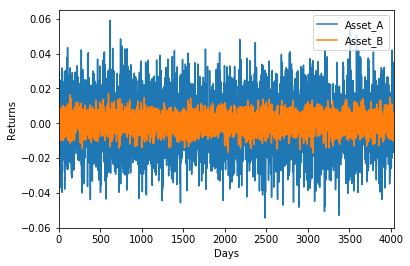

In [303]:
ax = df.plot()
ax.set_xlabel('Days')
ax.set_ylabel('Returns')

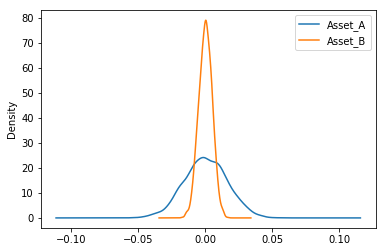

In [304]:
df.plot.kde()

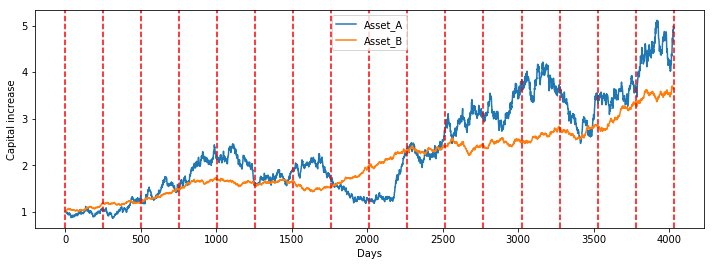

In [305]:
_=plt.figure(figsize = (12, 4))
_=plt.plot(dt	.index, dt['Asset_A'])
_=plt.plot(dt.index, dt['Asset_B'])
for i in list(dt[dt['Flag'] == 1].index):
    _=plt.axvline(i, color = 'red', linestyle = '--')
_=plt.xlabel('Days')
_=plt.ylabel('Capital increase')
_=plt.legend()

In [307]:
# The beginning and end of the sample
start = list(dt[dt['Flag'] == 1].index)[:-1]
stop = list(dt[dt['Flag'] == 1].index)[1:] 
del dt['Flag']

In [308]:
# weights over time
weigts = []
for i in np.linspace(.5, 1, 15):
    weigts.append(round(i, 2))

In [309]:
w_a = []
w_b = []
print('weight of asset B')
for i in range(len(weigts)):
    a, b = weight_cor(df, start[i], stop[i], weigts[i], length = 252)
    w_a.append(a)
    w_b.append(b)

weight of asset B
0.5|0.54|0.57|0.61|0.64|0.68|0.71|0.75|0.79|0.82|0.86|0.89|0.93|0.96|1.0|

Text(0, 0.5, 'Capital increase')

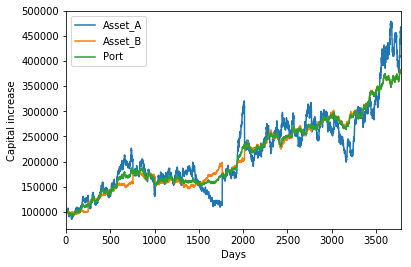

In [310]:
a_a = []
a_b = []
# f_f = []
p = []
pv = 100000
for i in range(len(w_a)):
    j = i + 1
    weig = [w_a[i], w_b[i]]
    weig = [round(pv * k, 2) for k in weig]
    w = [.5, .5]
    temp = df.copy()
    temp = filter_df(df, start[j], stop[j])
    work = pd.DataFrame({'Asset_A': cap_in(list(temp['Asset_A'])), 
                         'Asset_B': cap_in(list(temp['Asset_B']))})
    work['T_A'] = work['Asset_A'] * pv
    a_a.extend(list(work['T_A']))
    work['T_B'] = work['Asset_B'] * pv
    a_b.extend(list(work['T_B']))
#     work['50/50'] = work['Asset_A'] * w[0] + work['Asset_B'] * w[1]
#     f_f.extend(list(work['50/50']))
    work['A'] = work['Asset_A'] * weig[0]
    work['B'] = work['Asset_B'] * weig[1]
    work['Port'] = work['A'] + work['B']
    pv = list(work['Port'])[len(work) - 1]
    p.extend(list(work['Port']))
main = pd.DataFrame({'Asset_A': a_a, 'Asset_B': a_b, 'Port': p})
ax = main.plot()
ax.set_xlabel('Days')
ax.set_ylabel('Capital increase')

In [311]:
main_i = main.apply(lambda x: np.log(x) - np.log(x).shift(1))
main_i.dropna(inplace=True)
np.mean(main_i) * 252

Asset_A    0.102497
Asset_B    0.088786
Port       0.088756
dtype: float64

In [312]:
np.std(main_i) * np.sqrt(252)

Asset_A    0.300098
Asset_B    0.108308
Port       0.097794
dtype: float64

In [321]:
a = series(4032, .20, .40)
b = series(4032, .07, .08)
df = pd.DataFrame({'Asset_A': a, 'Asset_B': b})
dt = pd.DataFrame({'Asset_A': cap_in(a), 'Asset_B': cap_in(b)})
flag(dt)

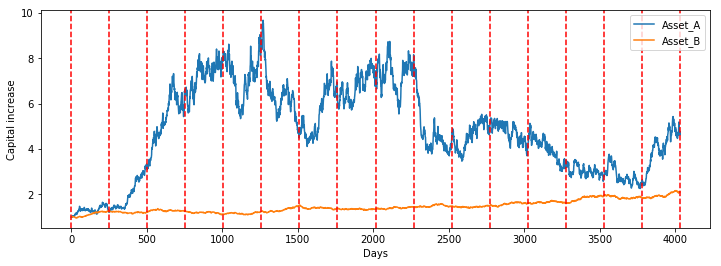

In [322]:
_=plt.figure(figsize = (12, 4))
_=plt.plot(dt	.index, dt['Asset_A'])
_=plt.plot(dt.index, dt['Asset_B'])
for i in list(dt[dt['Flag'] == 1].index):
    _=plt.axvline(i, color = 'red', linestyle = '--')
_=plt.xlabel('Days')
_=plt.ylabel('Capital increase')
_=plt.legend()

In [323]:
# The beginning and end of the sample
start = list(dt[dt['Flag'] == 1].index)[:-1]
stop = list(dt[dt['Flag'] == 1].index)[1:] 
del dt['Flag']

In [324]:
# weights over time
weigts = []
for i in np.linspace(.5, 1, 15):
    weigts.append(round(i, 2))

In [325]:
w_a = []
w_b = []
print('weight of asset B')
for i in range(len(weigts)):
    a, b = weight_cor(df, start[i], stop[i], weigts[i], length = 252)
    w_a.append(a)
    w_b.append(b)

weight of asset B
0.5|0.54|0.57|0.61|0.64|0.68|0.71|0.75|0.79|0.82|0.86|0.89|0.93|0.96|1.0|

Text(0, 0.5, 'Capital increase')

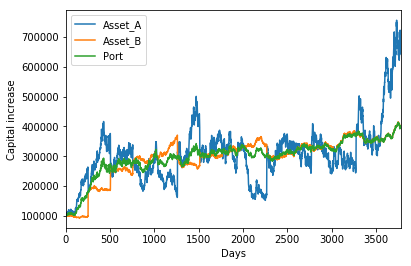

In [326]:
a_a = []
a_b = []
# f_f = []
p = []
pv = 100000
for i in range(len(w_a)):
    j = i + 1
    weig = [w_a[i], w_b[i]]
    weig = [round(pv * k, 2) for k in weig]
    w = [.5, .5]
    temp = df.copy()
    temp = filter_df(df, start[j], stop[j])
    work = pd.DataFrame({'Asset_A': cap_in(list(temp['Asset_A'])), 
                         'Asset_B': cap_in(list(temp['Asset_B']))})
    work['T_A'] = work['Asset_A'] * pv
    a_a.extend(list(work['T_A']))
    work['T_B'] = work['Asset_B'] * pv
    a_b.extend(list(work['T_B']))
#     work['50/50'] = work['Asset_A'] * w[0] + work['Asset_B'] * w[1]
#     f_f.extend(list(work['50/50']))
    work['A'] = work['Asset_A'] * weig[0]
    work['B'] = work['Asset_B'] * weig[1]
    work['Port'] = work['A'] + work['B']
    pv = list(work['Port'])[len(work) - 1]
    p.extend(list(work['Port']))
main = pd.DataFrame({'Asset_A': a_a, 'Asset_B': a_b, 'Port': p})
ax = main.plot()
ax.set_xlabel('Days')
ax.set_ylabel('Capital increase')

In [327]:
main_i = main.apply(lambda x: np.log(x) - np.log(x).shift(1))
main_i.dropna(inplace=True)
np.mean(main_i) * 252

Asset_A    0.126331
Asset_B    0.092834
Port       0.092704
dtype: float64

In [328]:
np.std(main_i) * np.sqrt(252)

Asset_A    0.482875
Asset_B    0.216459
Port       0.137741
dtype: float64